<a href="https://colab.research.google.com/github/harnalashok/LLMs/blob/main/%E2%9A%A1LLM_02_Embeddings%2C_Vector_Databases_and_Search%E2%9A%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended" 9th April, 2024
# Ref: https://www.kaggle.com/code/aliabdin1/llm-02-embeddings-vector-databases-and-search

## ⚡ Further Notebooks In This Course ⚡

**Notebooks:**
1. [LLM 01 - How to use LLMs with Hugging Face](https://www.kaggle.com/code/aliabdin1/llm-01-llms-with-hugging-face)
2. [LLM 02 - Embeddings, Vector Databases, and Search](https://www.kaggle.com/code/aliabdin1/llm-02-embeddings-vector-databases-and-search)
3. [LLM 03 - Building LLM Chain](https://www.kaggle.com/code/aliabdin1/llm-03-building-llm-chain)
4. [LLM 04a - Fine-tuning LLMs](https://www.kaggle.com/code/aliabdin1/llm-04a-fine-tuning-llms)
4. [LLM 04b - Evaluating LLMs](https://www.kaggle.com/code/aliabdin1/llm-04b-evaluating-llms)
5. [LLM 05 - Biased LLMs and Society](https://www.kaggle.com/code/aliabdin1/llm-05-llms-and-society)
6. [LLM 06 - LLMOps](https://www.kaggle.com/code/aliabdin1/llm-06-llmops)

**Hands-on Lab Notebooks:**
1. [LLM 01L - How to use LLMs with Hugging Face Lab](https://www.kaggle.com/code/aliabdin1/llm-01l-llms-with-hugging-face-lab)
2. [LLM 02L - Embeddings, Vector Databases, and Search Lab](https://www.kaggle.com/code/aliabdin1/llm-02l-embeddings-vector-databases-and-search)
3. [LLM 03L - Building LLM Chains Lab](https://www.kaggle.com/code/aliabdin1/llm-03l-building-llm-chains-lab)
4. [LLM 04L - Fine-tuning LLMs Lab](https://www.kaggle.com/code/aliabdin1/llm-04l-fine-tuning-llms-lab)
5. [LLM 05L - Biased LLMs and Society Lab](https://www.kaggle.com/code/aliabdin1/llm-05l-llms-and-society-lab)

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Embeddings, Vector Databases, and Search

Converting text into embedding vectors is the first step to any text processing pipeline. As the amount of text gets larger, there is often a need to save these embedding vectors into a dedicated vector index or library, so that developers won't have to recompute the embeddings and the retrieval process is faster. We can then search for documents based on our intended query and pass these relevant documents into a language model (LM) as additional context. We also refer to this context as supplying the LM with "state" or "memory". The LM then generates a response based on the additional context it receives!

In this notebook, we will implement the full workflow of text vectorization, vector search, and question answering workflow. While we use [FAISS](https://faiss.ai/) (vector library) and [ChromaDB](https://docs.trychroma.com/) (vector database), and a Hugging Face model, know that you can easily swap these tools out for your preferred tools or models!

<img src="https://files.training.databricks.com/images/llm/updated_vector_search.png" width=1000 target="_blank" >

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Implement the workflow of reading text, converting text to embeddings, saving them to FAISS and ChromaDB
2. Query for similar documents using FAISS and ChromaDB
3. Apply a Hugging Face language model for question answering!

In [ ]:
# Downgrade pydantic, else problem in importing chromadb
# Refer: https://github.com/chroma-core/chroma/issues/774

In [8]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [9]:
! pip install pydantic==1.9.0
!pip install --upgrade accelerate

In [10]:
!pip install faiss-cpu==1.7.4 chromadb==0.3.21

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Step 1: Reading data

In this section, we are going to use the data on <a href="https://newscatcherapi.com/" target="_blank">news topics collected by the NewsCatcher team</a>, who collect and index news articles and release them to the open-source community. The dataset can be downloaded from <a href="https://www.kaggle.com/kotartemiy/topic-labeled-news-dataset" target="_blank">Kaggle</a>.

In [12]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import InputExample

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

import pandas as pd
import numpy as np

import chromadb
from chromadb.config import Settings



import faiss
import json

In [13]:
pdf = pd.read_csv("/gdrive/MyDrive/Colab_data_files/topic-labeled-news-dataset/labelled_newscatcher_dataset.csv", sep=";")
pdf["id"] = pdf.index
display(pdf)

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4
...,...,...,...,...,...,...,...
108769,NATION,https://www.vanguardngr.com/2020/08/pdp-govern...,vanguardngr.com,2020-08-08 02:40:00,PDP governors’ forum urges security agencies t...,en,108769
108770,BUSINESS,https://www.patentlyapple.com/patently-apple/2...,patentlyapple.com,2020-08-08 01:27:12,"In Q2-20, Apple Dominated the Premium Smartpho...",en,108770
108771,HEALTH,https://www.belfastlive.co.uk/news/health/coro...,belfastlive.co.uk,2020-08-12 17:01:00,Coronavirus Northern Ireland: Full breakdown s...,en,108771
108772,ENTERTAINMENT,https://www.thenews.com.pk/latest/696364-paul-...,thenews.com.pk,2020-08-05 04:59:00,Paul McCartney details post-Beatles distress a...,en,108772


## Vector Library: FAISS

Vector libraries are often sufficient for small, static data. Since it's not a full-fledged database solution, it doesn't have the CRUD (Create, Read, Update, Delete) support. Once the index has been built, if there are more vectors that need to be added/removed/edited, the index has to be rebuilt from scratch.

That said, vector libraries are easy, lightweight, and fast to use. Examples of vector libraries are [FAISS](https://faiss.ai/), [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [ANNOY](https://github.com/spotify/annoy), and [HNSM](https://arxiv.org/abs/1603.09320).

FAISS has several ways for similarity search: L2 (Euclidean distance), cosine similarity. You can read more about their implementation on their [GitHub](https://github.com/facebookresearch/faiss/wiki/Getting-started#searching) page or [blog post](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/). They also published their own [best practice guide here](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index).

If you'd like to read up more on the comparisons between vector libraries and databases, [here is a good blog post](https://weaviate.io/blog/vector-library-vs-vector-database#feature-comparison---library-versus-database).

The overall workflow of FAISS is captured in the diagram below.

<img src="https://miro.medium.com/v2/resize:fit:1400/0*ouf0eyQskPeGWIGm" width=700>

Source: [How to use FAISS to build your first similarity search by Asna Shafiq](https://medium.com/loopio-tech/how-to-use-faiss-to-build-your-first-similarity-search-bf0f708aa772).

In [14]:
pdf_subset = pdf.head(1000)
pdf_subset

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4
...,...,...,...,...,...,...,...
995,TECHNOLOGY,https://www.androidcentral.com/mate-40-will-be...,androidcentral.com,2020-08-07 17:12:33,The Mate 40 will be the last Huawei phone with...,en,995
996,SCIENCE,https://www.cnn.com/2020/08/17/africa/stone-ag...,cnn.com,2020-08-17 17:10:00,"Early humans knew how to make comfy, pest-free...",en,996
997,HEALTH,https://www.tenterfieldstar.com.au/story/68776...,tenterfieldstar.com.au,2020-08-13 03:26:06,Regional Vic set for virus testing blitz,en,997
998,HEALTH,https://news.sky.com/story/coronavirus-trials-...,news.sky.com,2020-08-13 13:22:58,Coronavirus: Trials of second contact-tracing ...,en,998


In [ ]:
# For the meaning of notation --> See StackOverflow:
#  https://stackoverflow.com/a/41193772
# In Python 3.5 though, PEP 484 -- Type Hints attaches
#   a single meaning to this: -> is used to indicate the type that the function returns.

#def example_create_fn(doc1: pd.Series) -> InputExample:
#    """
#    Helper function that outputs a sentence_transformer guid, label, and text
#    """
#    return InputExample(texts=[doc1])


In [ ]:
#faiss_train_examples = pdf_subset.apply(
#                                        lambda x: example_create_fn(x["title"]), axis=1
#                                       ).tolist()

#faiss_train_examples[:4]

In [ ]:
#faiss_train_examples[0]

### Step 2: Vectorize text into embedding vectors
We will be using `Sentence-Transformers` [library](https://www.sbert.net/) to load a language model to vectorize our text into embeddings. The library hosts some of the most popular transformers on [Hugging Face Model Hub](https://huggingface.co/sentence-transformers).
Here, we are using the `model = SentenceTransformer("all-MiniLM-L6-v2")` to generate embeddings.

In [15]:
! mkdir /content/cache

In [16]:
# The code will download the model: all-MiniLM-L6-v2
model = SentenceTransformer(
                             "all-MiniLM-L6-v2",
                              cache_folder="/content/cache/"
                           )  # Use a pre-cached model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
pdf_subset.title.values.tolist()[:3]

["A closer look at water-splitting's solar fuel potential",
 'An irresistible scent makes locusts swarm, study finds',
 'Artificial intelligence warning: AI will know us better than we know ourselves']

In [ ]:
faiss_title_embedding = model.encode(
                                      pdf_subset.title.values.tolist()
                                    )

In [ ]:
pdf_subset.title.values.tolist()[0]
faiss_title_embedding[0]

len(pdf_subset.title.values.tolist()[0])  # 55
len(faiss_title_embedding[0]) #   384

384

In [ ]:
len(faiss_title_embedding[0]), len(pdf_subset.title.values.tolist()), len(faiss_title_embedding)

(384, 1000, 1000)

### Step 3: Saving embedding vectors to FAISS index
Below, we create the FAISS index object based on our embedding vectors, normalize vectors, and add these vectors to the FAISS index.    

A brief is [here](https://www.pinecone.io/learn/series/faiss/vector-indexes/)    
[Tutorial](https://www.pinecone.io/learn/series/faiss/faiss-tutorial/)     

See [here](https://github.com/facebookresearch/faiss/wiki/Pre--and-post-processing)


In [ ]:
# https://www.golinuxcloud.com/faiss-python-api/

### Demo begin

In [ ]:
# Generate random vectors for the dataset and for query set:

d =   5  # Dimension of vectors
nb = 10  # Number of vectors in the dataset
nq =  8  # Number of vectors in the query set


In [ ]:
# Our dataset
xb = np.random.random((nb, d)).astype('float32')

xb.shape
xb[:2,:]

array([[0.8069973 , 0.5924297 , 0.60334986, 0.2699154 , 0.8960901 ],
       [0.3963294 , 0.8954987 , 0.62524843, 0.84096605, 0.35508114]],
      dtype=float32)

In [ ]:
# our query set:

xq = np.random.random((nq, d)).astype('float32')
xq[:2,:]

array([[0.23264916, 0.14882264, 0.52558064, 0.3346536 , 0.06864229],
       [0.10586061, 0.8803955 , 0.80877435, 0.0863931 , 0.3542983 ]],
      dtype=float32)

In [ ]:
# Create blank faiss index of size 'd':

f_index = faiss.IndexFlatIP(d)

# Add vectors to this blank index:
f_index.add(xb)

print(f"Index total dataset vectors: {f_index.ntotal}")

Index total dataset vectors: 10


In [ ]:
# Number of nearest neighbors to search for
k = 4

# Perform search
D, I = f_index.search(xq, k)

# D contains the distances,
#  and I contains the indices of four the neighbors:
print(f"Distances:\n {D}")
print(f"\nIndices:\n {I}")

Distances:
 [[0.8898378  0.85990053 0.812604   0.744861  ]
 [1.5344919  1.4418073  1.4357775  1.4180545 ]
 [1.496304   1.4772478  1.3402567  1.3259383 ]
 [1.3107897  1.2931021  1.1194755  1.0963792 ]
 [1.5070404  1.4828259  1.4375236  1.4190803 ]
 [1.6231968  1.5787647  1.55034    1.5309011 ]
 [1.3638006  1.30781    1.3030542  1.0373536 ]
 [2.107591   2.0621881  1.9555713  1.928782  ]]

Indices:
 [[5 1 4 0]
 [1 4 0 5]
 [5 4 1 0]
 [5 0 4 1]
 [7 0 5 4]
 [4 5 1 2]
 [0 3 5 7]
 [4 7 6 5]]


In [ ]:
# Number of nearest neighbors to search for
k = 3

# Perform search
D, I = f_index.search(xq, k)

# D contains the distances,
#  and I contains the indices of four the neighbors:
print(f"Distances:\n {D}")
print(f"\nIndices:\n {I}")

Distances:
 [[0.8898378  0.85990053 0.812604  ]
 [1.5344919  1.4418073  1.4357775 ]
 [1.496304   1.4772478  1.3402567 ]
 [1.3107897  1.2931021  1.1194755 ]
 [1.5070404  1.4828259  1.4375236 ]
 [1.6231968  1.5787647  1.55034   ]
 [1.3638006  1.30781    1.3030542 ]
 [2.107591   2.0621881  1.9555713 ]]

Indices:
 [[5 1 4]
 [1 4 0]
 [5 4 1]
 [5 0 4]
 [7 0 5]
 [4 5 1]
 [0 3 5]
 [4 7 6]]


In [ ]:
data_b = pd.DataFrame(xb)
data_b['id'] = np.arange(0, len(data_b)).astype("int")
data_b

,0,1,2,3,4,id
0,0.806997,0.592430,0.603350,0.269915,0.896090,0
1,0.396329,0.895499,0.625248,0.840966,0.355081,1
2,0.673106,0.932235,0.428555,0.147680,0.401225,2
3,0.100797,0.207235,0.679722,0.666532,0.981568,3
4,0.803886,0.870182,0.512445,0.605881,0.349443,4
5,0.975369,0.498737,0.760238,0.435936,0.629957,5
6,0.739038,0.742264,0.320610,0.685255,0.340541,6
7,0.970208,0.773552,0.018242,0.083125,0.923589,7
8,0.221448,0.114236,0.791161,0.177612,0.397906,8
9,0.243841,0.273077,0.559670,0.611688,0.573656,9


In [ ]:
data_q = pd.DataFrame(xq)
data_q['id'] = np.arange(0, len(data_q)).astype("int")
data_q

,0,1,2,3,4,id
0,0.232649,0.148823,0.525581,0.334654,0.068642,0
1,0.105861,0.880395,0.808774,0.086393,0.354298,1
2,0.663558,0.566173,0.561774,0.235711,0.058546,2
3,0.293414,0.416849,0.734720,0.003219,0.407550,3
4,0.498474,0.674664,0.273673,0.179612,0.521451,4
5,0.473882,0.894262,0.684950,0.082320,0.180874,5
6,0.231520,0.098988,0.666955,0.071212,0.777481,6
7,0.975308,0.962774,0.039048,0.566804,0.350104,7


In [ ]:
data_b_index = np.array(data_b['id'].values).flatten().astype("int")
data_b_index

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
fi_index = faiss.IndexIDMap(
                         faiss.IndexFlatIP(
                                           data_b.shape[1]
                                          )
                        )

In [ ]:
fi_index.add_with_ids(data_b.values, data_b_index)

In [ ]:
# Number of nearest neighbors to search for
k = 2

# Perform search
fi_index.search(data_q.values, k)



(array([[ 0.8898378 ,  0.85990053],
        [ 9.974966  ,  8.920208  ],
        [18.808586  , 16.721235  ],
        [27.83234   , 24.856615  ],
        [36.86795   , 32.643368  ],
        [45.897213  , 40.835594  ],
        [54.946327  , 48.91226   ],
        [64.07013   , 56.596836  ]], dtype=float32),
 array([[5, 1],
        [9, 8],
        [9, 8],
        [9, 8],
        [9, 8],
        [9, 8],
        [9, 8],
        [9, 8]]))

In [ ]:
# Number of nearest neighbors to search for
k = 3

# Perform search
fi_index.search(data_q.values, k)

(array([[ 0.8898378 ,  0.85990053,  0.812604  ],
        [ 9.974966  ,  8.920208  ,  8.1329    ],
        [18.808586  , 16.721235  , 15.165668  ],
        [27.83234   , 24.856615  , 21.997208  ],
        [36.86795   , 32.643368  , 29.50704   ],
        [45.897213  , 40.835594  , 36.337914  ],
        [54.946327  , 48.91226   , 43.037354  ],
        [64.07013   , 56.596836  , 51.062187  ]], dtype=float32),
 array([[5, 1, 4],
        [9, 8, 7],
        [9, 8, 7],
        [9, 8, 7],
        [9, 8, 7],
        [9, 8, 7],
        [9, 8, 7],
        [9, 8, 7]]))

### Demo ends

### Step 3: Saving embedding vectors to FAISS index
Below, we create the FAISS index object based on our embedding vectors, normalize vectors, and add these vectors to the FAISS index.    

A brief is [here](https://www.pinecone.io/learn/series/faiss/vector-indexes/)    
[Tutorial](https://www.pinecone.io/learn/series/faiss/faiss-tutorial/)     

See [here](https://github.com/facebookresearch/faiss/wiki/Pre--and-post-processing)


In [ ]:
pdf_to_index = pdf_subset.set_index(["id"], drop=False)
pdf_to_index.head(5)

,topic,link,domain,published_date,title,lang,id
id,,,,,,,
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4


In [ ]:
id_index = np.array(
                    pdf_to_index.id.values
                    )

In [ ]:
id_index.shape
type(id_index)
type(id_index[0])

(1000,)

numpy.ndarray

numpy.int64

In [ ]:
id_index = np.array(
                    pdf_to_index.id.values
                    ).flatten().astype("int")

id_index[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
id_index.shape
type(id_index)
type(id_index[0])

(1000,)

numpy.ndarray

numpy.int64

In [ ]:
content_encoded_normalized = faiss_title_embedding.copy()

In [ ]:
faiss.normalize_L2(content_encoded_normalized)

In [ ]:
len(faiss_title_embedding[0])  # 384

384

In [ ]:
# Create a blank flat index of size len(faiss_title_embedding)
# Flat index is prepared using IP (inner product):

faiss.IndexFlatIP(len(faiss_title_embedding))

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b18d3fa4de0> >

In [ ]:
# Index that translates search results to ids:

help(faiss.IndexIDMap)

In [ ]:
faiss.IndexIDMap(
                  faiss.IndexFlatIP(
                                     len(faiss_title_embedding[0])
                                     )
                  )

<faiss.swigfaiss_avx2.IndexIDMap; proxy of <Swig Object of type 'faiss::IndexIDMapTemplate< faiss::Index > *' at 0x7e9e80f95a70> >

In [ ]:
content_encoded_normalized[:3]

array([[-0.11270553,  0.04076539,  0.02181418, ..., -0.01874595,
        -0.03136873,  0.0682483 ],
       [-0.02187164, -0.03349994,  0.07321803, ...,  0.03362319,
        -0.00563893, -0.00630974],
       [ 0.01608378,  0.00279448, -0.01504421, ..., -0.00706246,
         0.00905904, -0.02835052]], dtype=float32)

In [ ]:
# Index1DMap translates search results to IDs: https://faiss.ai/cpp_api/file/IndexIDMap_8h.html#_CPPv4I0EN5faiss18IndexIDMapTemplateE
# The IndexFlatIP below builds index

index_content = faiss.IndexIDMap(faiss.IndexFlatIP(len(faiss_title_embedding[0])))

In [ ]:
index_content.add_with_ids(content_encoded_normalized, id_index)

## Step 4: Search for relevant documents

We define a search function below to first vectorize our query text, and then search for the vectors with the closest distance.

In [ ]:
def search_content(query, pdf_to_index, k=3):
    query_vector = model.encode([query])
    faiss.normalize_L2(query_vector)

    # We set k to limit the number of vectors we want to return
    top_k = index_content.search(query_vector, k)
    ids = top_k[1][0].tolist()
    similarities = top_k[0][0].tolist()
    results = pdf_to_index.loc[ids]
    results["similarities"] = similarities
    return results

Tada! Now you can query for similar content! Notice that you did not have to configure any database networks beforehand nor pass in any credentials. FAISS works locally with your code.

In [ ]:
display(search_content("animal", pdf_to_index))

,topic,link,domain,published_date,title,lang,id,similarities
id,,,,,,,,
176,TECHNOLOGY,https://www.pushsquare.com/news/2020/08/random...,pushsquare.com,2020-08-03 16:30:00,Random: You Can Pick Up and Pet Cats in Assass...,en,176,0.391902
975,HEALTH,https://www.news-medical.net/news/20200813/Res...,news-medical.net,2020-08-13 05:18:00,Researchers explore social behavior of animals...,en,975,0.376784
99,TECHNOLOGY,https://www.gematsu.com/2020/08/ghostwire-toky...,gematsu.com,2020-08-07 16:43:13,Ghostwire: Tokyo confirms dog petting,en,99,0.344058


Up until now, we haven't done the last step of conducting Q/A with a language model yet. We are going to demonstrate this with Chroma, a vector database.

## Vector Database: Chroma

Chroma is an open-source embedding database. The company just raised its [seed funding in April 2023](https://www.trychroma.com/blog/seed) and is quickly becoming popular to support LLM-based applications.

Chroma is the AI native open-source embeddings database. Using embeddings, Chroma lets developers add state and memory to their AI-enabled applications.

Developers use Chroma to give LLMs pluggable knowledge about their data, facts, tools, and prevent hallucinations. Many developers have said they want "ChatGPT but for my data" - and Chroma provides the "for my data" bridge through embedding-based document retrieval.

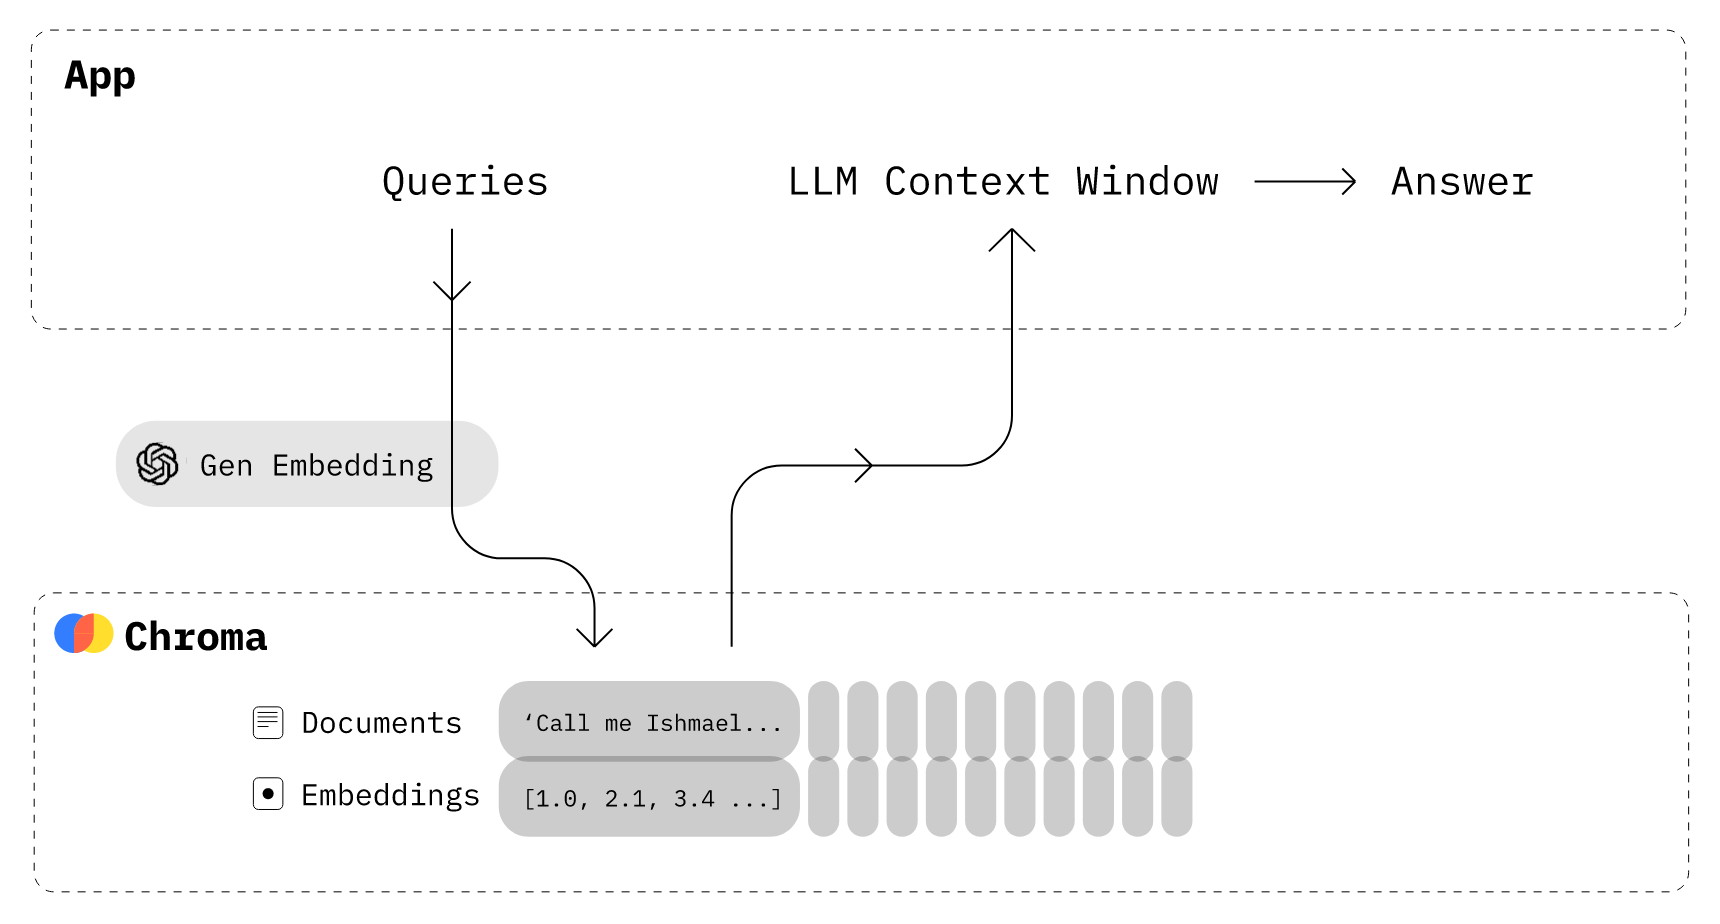

Chroma comes 'batteries included' with everything developers need to store, embed, and query data with powerful features like filtering built in, with more features like automatic clustering and query relevance coming soon.

It's been amazing to see all the ways that developers have picked up Chroma over the past 5 weeks since launch, crossing 35k python downloads in the past month.

*“Chroma’s vector search is as easy as getting started with SQLite - easy to start, open source, scales as you need. For Prefect, I recommend it to our customers for the same reason - they can start flexibly on their own terms as they figure out what they need, and then have the confidence of commercial support down the road.”


Why we built Chroma?

Chroma was founded on the principle that models can be understood through interpretability of their latent spaces, and while we were experimenting with that we needed an open-source vector database that was powerful and easy-to-use. We evaluated the existing products, but found they were difficult to use and fundamentally built for a different use case (web scale semantic search). We built Chroma for ourselves, because it was the product we needed and wanted.

#### So, globally, the way to use Chroma is as follows:

> 1. Create our collection, which is the equivalent of a table in a relational database. In this process, we must indicate which model Chroma should use to convert the texts into embeddings. As we will see later, there are several available. Collections are where you will store your embeddings, documents, and additional metadata

> 2. Send Chroma some text that you want it to save, along with whatever metadata you want for filtering the text. When Chroma receives the text, it will take care of converting it to embedding.

> 3. Query Chroma by sending a text or an embedding, we will receive the most similar n documents, without n a parameter of the query. In addition, we can filter the query based on metadata so that it is only executed on the documents that meet a series of criteria.

#### How to create a Chroma database with `DuckDB` as backend
chromadb `Settings()`; see [here](https://github.com/chroma-core/chroma/blob/c665838b0d143e2c2ceb82c4ade7404dc98124ff/chromadb/config.py#L83)

To create the Chroma database and make it accessible, Chroma provides the `Settings` class, which allows us to define how we want it to be implemented. In our case, there are two parameters that we must define:

>`chroma_db_impl`: indicates which backend will use Chroma. In our case, we must indicate `duckdb+parquet`
> `persist_directory` : allows us to indicate in which folder the parquet files will be saved to achieve persistent storage.

In [19]:
chroma_client = chromadb.Client(
                                Settings(
                                        chroma_db_impl="duckdb+parquet",      # Default is sqlite database
                                        persist_directory="/content/cache/",  # this is an optional argument.
                                                                              # If you don't supply this, the
                                                                              # data will be ephemeral
                                      )
                              )

The nice thing about ChromaDB is that if you don't supply a model to vectorize text into embeddings, it will automatically load a default embedding function, i.e. `SentenceTransformerEmbeddingFunction`. It can handle tokenization, embedding, and indexing automatically for you. If you would like to change the embedding model, read [here on how to do that](https://docs.trychroma.com/embeddings). TLDR: you can add an optional `model_name` argument.

You can read [the documentation here](https://docs.trychroma.com/usage-guide#using-collections) on rules for collection names.

In [20]:
# Are there any existing collections?
chroma_client.list_collections()   # Default []

[]

In [21]:
# Create a collection:
collection_name = "my_news"
collection = chroma_client.create_collection(
                                              name=collection_name
                                             )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
# Are there any existing collections?
chroma_client.list_collections()   # Default []

[Collection(name=my_news)]

### Step 1: Add data to collection

Since we are re-using the same data, we can skip the step of reading data. As mentioned in the text above, Chroma can take care of text vectorization for us, so we can directly add text to the collection and Chroma will convert the text into embeddings behind the scene.

In [24]:
pdf_subset.head(3)

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2


Each document must have a unique `id` associated with it and it is up to you to check that there are no duplicate ids.

Adding data to collection will take some time to run, especially when there is a lot of data. In the cell below, we intentionally write only a subset of data to the collection to speed things up.

In [33]:
[{"topic": topic} for topic in pdf_subset["topic"][:5].tolist()]
[{"topic": topic} for topic in pdf_subset["topic"][:5]]

[{'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'}]

[{'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'},
 {'topic': 'SCIENCE'}]

In [34]:
collection.add(
                documents=pdf_subset["title"][:100].tolist(),
                metadatas=[{"topic": topic} for topic in pdf_subset["topic"][:100]],
                ids=["id" + str(x) for x in range(100)],
              )

### Step 2: Query for 10 relevant documents on "space"

We will return 10 most relevant documents. You can think of `10` as 10 nearest neighbors. You can also change the number of results returned as well.

In [35]:
results = collection.query(
                           query_texts=["space"],
                           n_results=10
                           )

print(json.dumps(results, indent=4))

{
    "ids": [
        [
            "id72",
            "id7",
            "id30",
            "id26",
            "id23",
            "id76",
            "id69",
            "id40",
            "id47",
            "id75"
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "Beck teams up with NASA and AI for 'Hyperspace' visual album experience",
            "Orbital space tourism set for rebirth in 2021",
            "NASA drops \"insensitive\" nicknames for cosmic objects",
            "\u2018It came alive:\u2019 NASA astronauts describe experiencing splashdown in SpaceX Dragon",
            "Hubble Uses Moon As \u201cMirror\u201d to Study Earth\u2019s Atmosphere \u2013 Proxy in Search of Potentially Habitable Planets Around Other Stars",
            "Australia's small yet crucial part in the mission to find life on Mars",
            "NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico",
            "SpaceX's Starship spacecraft saw 150 mete

### Bonus: Add filter statement

In addition to conducting relevancy search, we can also add filter statements. Refer to the [documentation](https://docs.trychroma.com/usage-guide#using-where-filters) for more information.

In [45]:
collection.query(
                  query_texts=["space"],
                  where={"topic": "SCIENCE"},
                  n_results=10
                )

{'ids': [['id7',
   'id30',
   'id26',
   'id23',
   'id76',
   'id69',
   'id40',
   'id47',
   'id75',
   'id52']],
 'embeddings': None,
 'documents': [['Orbital space tourism set for rebirth in 2021',
   'NASA drops "insensitive" nicknames for cosmic objects',
   '‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon',
   'Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars',
   "Australia's small yet crucial part in the mission to find life on Mars",
   'NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico',
   "SpaceX's Starship spacecraft saw 150 meters high",
   'NASA’s InSight lander shows what’s beneath Mars’ surface',
   'Alien base on Mercury: ET hunters claim to find huge UFO',
   'SpaceX Crew-1 mission with NASA, first fully operational crewed mission to space to launch in October']],
 'metadatas': [[{'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': '

### Bonus: Update data in a collection

Unlike a vector library, vector databases support changes to the data so we can update or delete data.

Indeed, we can update or delete data in a Chroma collection.

In [46]:
collection.delete(
                  ids=["id0"]
                  )

[UUID('d7a8f476-5d7a-45aa-8f52-9ffb04653a08')]

The record with `ids=0` is no longer present.

In [47]:
collection.get(
               ids=["id0"],
               )

{'ids': [], 'embeddings': None, 'documents': [], 'metadatas': []}

We can also update a specific data point.

In [48]:
collection.get(
               ids=["id2"],
              )

{'ids': ['id2'],
 'embeddings': None,
 'documents': ['Artificial intelligence warning: AI will know us better than we know ourselves'],
 'metadatas': [{'topic': 'SCIENCE'}]}

In [49]:
collection.update(
                  ids=["id2"],
                  metadatas=[{"topic": "TECHNOLOGY"}],
                  )

In [50]:
collection.get(
                ids=["id2"],
              )

{'ids': ['id2'],
 'embeddings': None,
 'documents': ['Artificial intelligence warning: AI will know us better than we know ourselves'],
 'metadatas': [{'topic': 'TECHNOLOGY'}]}

## Prompt engineering for question answering

Now that we have identified documents about space from the news dataset, we can pass these documents as additional context for a language model to generate a response based on them!

We first need to pick a `text-generation` model. Below, we use a Hugging Face model. You can also use OpenAI as well, but you will need to get an Open AI token and [pay based on the number of tokens](https://openai.com/pricing).

In [52]:
model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
                                          model_id,
                                          cache_dir="/content/cache/"
                                          )

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### Causal Language Modeling (CLM)
For types of models refer [here](https://medium.com/@tom_21755/understanding-causal-llms-masked-llm-s-and-seq2seq-a-guide-to-language-model-training-d4457bbd07fa)

>CLM is an autoregressive method where the model is trained to predict the next token in a sequence given the previous tokens. CLM is used in models like GPT-2 and GPT-3 and is well-suited for tasks such as text generation and summarization. However, CLM models have unidirectional context, meaning they only consider the past and not the future context when generating predictions.

>**Implementation**: In CLM, the model is trained to predict the next token in the sequence, given the previous tokens. During training, the input tokens are fed into the model, and the model predicts the probability distribution of the next token. The loss is calculated based on the model’s predictions and the actual target tokens, which are just the input tokens shifted by one position.

>**Architecture**: CLM is typically used with autoregressive models like GPT. These models use a unidirectional (left-to-right) Transformer architecture, where each token can only attend to the tokens that come before it. This prevents the model from “cheating” by attending to the target tokens during training.

>**Output Model**: A fine-tuned CLM model can generate coherent text by predicting one token at a time, making it suitable for text generation tasks. However, it may not be as effective at capturing bidirectional context compared to MLM models.

#### Masked Language Modeling (MLM)

>MLM is a training method used in models like BERT, where some tokens in the input sequence are masked, and the model learns to predict the masked tokens based on the surrounding context. MLM has the advantage of bidirectional context, allowing the model to consider both past and future tokens when making predictions. This approach is especially useful for tasks like text classification, sentiment analysis, and named entity recognition.

>**Implementation**: In MLM, the model is trained to predict masked tokens within the input sequence. During preprocessing, a certain percentage of tokens are randomly masked, and the model is trained to predict the original tokens at those masked positions. The loss is calculated based on the model’s predictions and the actual target tokens (the original tokens that were masked).

> **Architecture**: MLM is used with models like BERT, which use a bidirectional Transformer architecture. Unlike CLM models, MLM models can attend to all tokens in the input sequence during training, allowing them to capture context from both left and right.

>**Output Model**: A fine-tuned MLM model is better at understanding context and relationships between words in a sequence, making it suitable for tasks like text classification, sentiment analysis, named entity recognition, or question answering.

#### Sequence-to-Sequence (Seq2Seq)

>Seq2Seq models consist of an encoder-decoder architecture, where the encoder processes the input sequence and the decoder generates the output sequence. This approach is commonly used in tasks like machine translation, summarization, and question-answering. Seq2Seq models can handle more complex tasks that involve input-output transformations, making them versatile for a wide range of NLP tasks.

>**Implementation**: In seq2seq modeling, the model is trained to generate output sequences based on input sequences. The model consists of two parts: an encoder that encodes the input sequence into a latent representation, and a decoder that generates the output sequence based on this latent representation. The loss is calculated based on the model’s predictions and the actual target output tokens.

>**Architecture**: Seq2seq models typically use an encoder-decoder architecture, where both the encoder and decoder can be based on the Transformer architecture (e.g., T5, BART) or other architectures like LSTMs (e.g., the original seq2seq model). The encoder processes the input sequence and generates a context representation, while the decoder generates the output sequence based on the encoder’s output and its own hidden state.

>**Output Model**: A fine-tuned seq2seq model is better at tasks where the model needs to generate coherent output text based on input text, such as summarization, translation, or question answering.

In [53]:
lm_model = AutoModelForCausalLM.from_pretrained(
                                                model_id,
                                                cache_dir="/content/cache/"
                                                )

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=lm_model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    device_map="auto",
)

Here's where prompt engineering, which is developing prompts, comes in. We pass in the context in our `prompt_template` but there are numerous ways to write a prompt. Some prompts may generate better results than the others and it requires some experimentation to figure out how best to talk to the model. Each language model behaves differently to prompts.

Our prompt template below is inspired from a [2023 paper on program-aided language model](https://arxiv.org/pdf/2211.10435.pdf). The authors have provided their sample prompt template [here](https://github.com/reasoning-machines/pal/blob/main/pal/prompt/date_understanding_prompt.py).

The following links also provide some helpful guidance on prompt engineering:
- [Prompt engineering with OpenAI](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api)
- [GitHub repo that compiles best practices to interact with ChatGPT](https://github.com/f/awesome-chatgpt-prompts)

In [ ]:
question = "What's the latest news on space development?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"

In [ ]:
context

'#Beck teams up with NASA and AI for \'Hyperspace\' visual album experience #Orbital space tourism set for rebirth in 2021 #NASA drops "insensitive" nicknames for cosmic objects #‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon #Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars #Australia\'s small yet crucial part in the mission to find life on Mars #NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico #SpaceX\'s Starship spacecraft saw 150 meters high #NASA’s InSight lander shows what’s beneath Mars’ surface #Alien base on Mercury: ET hunters claim to find huge UFO'

In [ ]:
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Relevant context: #Beck teams up with NASA and AI for 'Hyperspace' visual album experience #Orbital space tourism set for rebirth in 2021 #NASA drops "insensitive" nicknames for cosmic objects #‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon #Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars #Australia's small yet crucial part in the mission to find life on Mars #NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico #SpaceX's Starship spacecraft saw 150 meters high #NASA’s InSight lander shows what’s beneath Mars’ surface #Alien base on Mercury: ET hunters claim to find huge UFO

 The user's question: What's the latest news on space development? There are few things as big and significant as NASA launching a new mission to put NASA astronauts in space on the ground. This week the White House invited space enthusiasts to share their take on this very exciting project.

Yay, you have just completed the implementation of your first text vectorization, search, and question answering workflow (that requires prompt engineering)!

In the lab, you will apply your newly gained knowledge to a different dataset. You can also check out the optional modules on Pinecone and Weaviate to learn how to set up vector databases that offer enterprise offerings.

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>